In [1]:
# Database and Collections
from src.domain.Query import JobQuery
from src.domain.Collection import LiveJobCollection

In [2]:
import pandas as pd
from decimal import Decimal

from matplotlib import pyplot as plt

from src.Logger import Logger

# DataFrame analyses
from src.DataFrameAnalyses import DataFramePlotGenerator, DataFrameChecker, DataFrameMetricsAnalyser

# Analysis utils
from src.utils.analysis.compare_sequences import compute_sum_levenshtein_distance, \
    compute_mean_kendall_tau, get_shared_operations_number

# Scheduler
from src.solvers.heuristics.GT_Scheduler import Scheduler

# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation

# Data access
from config.project_config import get_examples_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [3]:
# Hard termination condition for schedulers
max_time = 60*10     # 10 min

# File paths
examples_path = get_examples_path("GT", as_string= True)

# Simulation
simulation = ProductionSimulation(shift_length= 1440)

# Logger
logger = Logger(log_file = f"{examples_path}/experiment_logger.log")

In [4]:
# Jobs for 20 days (shifts)
timespan = 60*24*20

jobs = JobQuery.get_by_source_name_max_util_and_lt_arrival(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization = Decimal("0.95"),
    arrival_limit= timespan
)
#jobs = [job for job in all_jobs if job.earliest_start <=timespan]

jobs_collection = LiveJobCollection(jobs)
jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,0,1440,3327
1,01-09500-0001,01-06,47,1440,3648
2,01-09500-0002,01-01,112,1440,3140
3,01-09500-0003,01-05,155,1440,5310
4,01-09500-0004,01-04,196,1440,3017
5,01-09500-0005,01-02,396,1440,2640
...,...,...,...,...,...
411,01-09500-0411,01-03,28273,28800,31742
412,01-09500-0412,01-06,28292,28800,30032
413,01-09500-0413,01-02,28308,28800,30108


In [5]:
for job in list(jobs_collection.values())[:2]:
    print(f"{job.id = }")
    for operation in job.operations:
        print(f" {operation.position_number = } {operation.machine_name = } {operation.transition_time = }")

job.id = '01-09500-0000'
 operation.position_number = 0 operation.machine_name = 'M02' operation.transition_time = 0
 operation.position_number = 1 operation.machine_name = 'M00' operation.transition_time = 0
 operation.position_number = 2 operation.machine_name = 'M01' operation.transition_time = 0
 operation.position_number = 3 operation.machine_name = 'M05' operation.transition_time = 0
 operation.position_number = 4 operation.machine_name = 'M04' operation.transition_time = 0
 operation.position_number = 5 operation.machine_name = 'M06' operation.transition_time = 0
 operation.position_number = 6 operation.machine_name = 'M08' operation.transition_time = 0
 operation.position_number = 7 operation.machine_name = 'M09' operation.transition_time = 0
 operation.position_number = 8 operation.machine_name = 'M07' operation.transition_time = 0
 operation.position_number = 9 operation.machine_name = 'M03' operation.transition_time = 0
job.id = '01-09500-0001'
 operation.position_number = 0

### Add transition times to operations (not saved in DB)

In [6]:
from src.domain.Query import MachineInstanceQuery

machines_instances = MachineInstanceQuery.get_by_source_name_and_max_bottleneck_utilization(
    source_name="Fisher and Thompson 10x10",
    max_bottleneck_utilization=Decimal("0.95")
)

# Add transition times to operations
for machine_instance in machines_instances:
    for job in jobs_collection.values():
        for operation in job.operations:
            if operation.machine_name == machine_instance.name:
                operation.transition_time = machine_instance.transition_time

###  Add simulation durations to operations

In [7]:
from src.simulation.LognormalFactorGenerator import LognormalFactorGenerator

# Add simulation durations to operations
factor_gen = LognormalFactorGenerator(
    sigma=0.2,
    seed=42
)
jobs_collection.sort_jobs_by_id()
jobs_collection.sort_operations()
for job in jobs_collection.values():
    for operation in job.operations:
        sim_duration_float = operation.duration * factor_gen.sample()
        operation.sim_duration = int(sim_duration_float)

In [8]:
for job in list(jobs_collection.values())[:2]:
    print(job.id)
    for operation in job.operations:
        print(f" {operation.position_number = } {operation.machine_name = } {operation.transition_time = } {operation.sim_duration = } |")

01-09500-0000
 operation.position_number = 0 operation.machine_name = 'M02' operation.transition_time = 176 operation.sim_duration = 31 |
 operation.position_number = 1 operation.machine_name = 'M00' operation.transition_time = 225 operation.sim_duration = 76 |
 operation.position_number = 2 operation.machine_name = 'M01' operation.transition_time = 481 operation.sim_duration = 57 |
 operation.position_number = 3 operation.machine_name = 'M05' operation.transition_time = 99 operation.sim_duration = 70 |
 operation.position_number = 4 operation.machine_name = 'M04' operation.transition_time = 97 operation.sim_duration = 25 |
 operation.position_number = 5 operation.machine_name = 'M06' operation.transition_time = 59 operation.sim_duration = 96 |
 operation.position_number = 6 operation.machine_name = 'M08' operation.transition_time = 90 operation.sim_duration = 14 |
 operation.position_number = 7 operation.machine_name = 'M09' operation.transition_time = 30 operation.sim_duration = 66 |

## Day 1
- On day 0, the first jobs (production orders) arrive, so nothing can be planned yet
- On day 1, the initial planning takes place

In [9]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [10]:
# New jobs that must be scheduled
current_jobs_collection = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)

In [11]:
current_jobs_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,0,M02,None,31,None,0,1440,3327
1,01-09500-0000,01-07,1,M00,None,86,None,0,1440,3327
2,01-09500-0000,01-07,2,M01,None,46,None,0,1440,3327
3,01-09500-0000,01-07,3,M05,None,74,None,0,1440,3327
4,01-09500-0000,01-07,4,M04,None,32,None,0,1440,3327
5,01-09500-0000,01-07,5,M06,None,88,None,0,1440,3327
...,...,...,...,...,...,...,...,...,...,...
164,01-09500-0016,01-07,4,M04,None,32,None,1345,1440,4197
165,01-09500-0016,01-07,5,M06,None,88,None,1345,1440,4197
166,01-09500-0016,01-07,6,M08,None,19,None,1345,1440,4197


In [12]:
current_jobs_collection.to_jobs_dataframe()

,Job,Routing_ID,Arrival,Ready Time,Due Date
0,01-09500-0000,01-07,0,1440,3327
1,01-09500-0001,01-06,47,1440,3648
2,01-09500-0002,01-01,112,1440,3140
3,01-09500-0003,01-05,155,1440,5310
4,01-09500-0004,01-04,196,1440,3017
5,01-09500-0005,01-02,396,1440,2640
...,...,...,...,...,...
11,01-09500-0011,01-02,901,1440,3994
12,01-09500-0012,01-08,970,1440,3293
13,01-09500-0013,01-04,1054,1440,4647


### Scheduling

In [13]:
scheduler = Scheduler(
    jobs_collection = current_jobs_collection,
    schedule_start= day_start,
)

#solver.set_active_jobs_collection(None)

schedule_jobs_collection  = scheduler.get_schedule(
    priority_rule= "SLACK"
)

df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(f"{examples_path}/schedule_day_01.csv", index=False)
df_schedule


,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0004,01-04,0,M02,1440,14,1454,196,1440,3017
1,01-09500-0004,01-04,1,M00,1454,6,1460,196,1440,3017
2,01-09500-0004,01-04,2,M01,1531,22,1553,196,1440,3017
3,01-09500-0004,01-04,3,M05,1553,61,1614,196,1440,3017
4,01-09500-0004,01-04,4,M03,1655,26,1681,196,1440,3017
5,01-09500-0004,01-04,5,M04,1681,69,1750,196,1440,3017
...,...,...,...,...,...,...,...,...,...,...
164,01-09500-0003,01-05,4,M08,2758,48,2806,155,1440,5310
165,01-09500-0003,01-05,5,M09,2840,72,2912,155,1440,5310
166,01-09500-0003,01-05,6,M00,2912,47,2959,155,1440,5310


In [14]:
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule.to_csv(f"{examples_path}/schedule_day_01.csv", index=False)
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0004,01-04,0,M02,1440,14,1454,196,1440,3017
1,01-09500-0004,01-04,1,M00,1454,6,1460,196,1440,3017
2,01-09500-0004,01-04,2,M01,1531,22,1553,196,1440,3017
3,01-09500-0004,01-04,3,M05,1553,61,1614,196,1440,3017
4,01-09500-0004,01-04,4,M03,1655,26,1681,196,1440,3017
5,01-09500-0004,01-04,5,M04,1681,69,1750,196,1440,3017
...,...,...,...,...,...,...,...,...,...,...
164,01-09500-0003,01-05,4,M08,2758,48,2806,155,1440,5310
165,01-09500-0003,01-05,5,M09,2840,72,2912,155,1440,5310
166,01-09500-0003,01-05,6,M00,2912,47,2959,155,1440,5310


In [15]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
df_jobs_metrics

,Job,Routing_ID,Last Operation,End,Arrival,Ready Time,Due Date,Total Processing Time,Flowtime,Lateness,Tardiness,Earliness
0,01-09500-0004,01-04,9,2100,196,1440,3017,393,660,-917,0,917
1,01-09500-0000,01-07,9,2467,0,1440,3327,539,1027,-860,0,860
2,01-09500-0005,01-02,9,2008,396,1440,2640,568,568,-632,0,632
3,01-09500-0002,01-01,9,2131,112,1440,3140,510,691,-1009,0,1009
4,01-09500-0016,01-07,9,3192,1345,1440,4197,539,1752,-1005,0,1005
5,01-09500-0008,01-09,9,2433,861,1440,3289,540,993,-856,0,856
...,...,...,...,...,...,...,...,...,...,...,...,...
11,01-09500-0001,01-06,9,2598,47,1440,3648,416,1158,-1050,0,1050
12,01-09500-0010,01-06,9,2752,896,1440,3790,416,1312,-1038,0,1038
13,01-09500-0011,01-02,9,2873,901,1440,3994,568,1433,-1121,0,1121


In [16]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Tardiness")

Tardiness_Interval,0,0 - 60,60 - 120,>120
count,17,0,0,0


In [17]:
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,17,0,0,0,0,0


### Simulation

In [18]:
# simulation.run(schedule_collection = schedule_jobs_collection, start_time = day_start, end_time=day_end)
simulation.initialize_run(schedule_collection = schedule_jobs_collection, start_time=day_start)

[Day 1 00:00:00] Job 01-09500-0004 started on M02
[Day 1 00:00:00] Job 01-09500-0005 started on M01
[Day 1 00:09:00] Job 01-09500-0004 finished on M02 (after 09 minutes)
[Day 1 00:14:00] Job 01-09500-0000 started on M02
[Day 1 00:14:00] Job 01-09500-0004 started on M00
[Day 1 00:21:00] Job 01-09500-0004 finished on M00 (after 07 minutes)
[Day 1 00:21:00] Job 01-09500-0002 started on M00
[Day 1 00:45:00] Job 01-09500-0000 finished on M02 (after 31 minutes)
[Day 1 00:45:00] Job 01-09500-0016 started on M02
[Day 1 01:06:00] Job 01-09500-0002 finished on M00 (after 45 minutes)
[Day 1 01:15:00] Job 01-09500-0016 finished on M02 (after 30 minutes)
[Day 1 01:16:00] Job 01-09500-0002 started on M02
[Day 1 01:27:00] Job 01-09500-0005 finished on M01 (after 87 minutes)
[Day 1 01:31:00] Job 01-09500-0004 started on M01
[Day 1 01:31:00] Job 01-09500-0005 started on M00
[Day 1 01:52:00] Job 01-09500-0004 finished on M01 (after 21 minutes)
[Day 1 01:53:00] Job 01-09500-0008 started on M01
[Day 1 01:

In [19]:
finished_job_ops_collection = simulation.get_finished_operation_collection()
df_execution = finished_job_ops_collection.to_operations_dataframe()
df_execution

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0004,01-04,0,M02,1440,9,1449,196,1440,3017
1,01-09500-0004,01-04,1,M00,1454,7,1461,196,1440,3017
2,01-09500-0004,01-04,2,M01,1531,21,1552,196,1440,3017
3,01-09500-0004,01-04,3,M05,1553,49,1602,196,1440,3017
4,01-09500-0004,01-04,4,M03,1656,26,1682,196,1440,3017
5,01-09500-0004,01-04,5,M04,1689,82,1771,196,1440,3017
...,...,...,...,...,...,...,...,...,...,...
130,01-09500-0009,01-08,3,M05,2829,38,2867,876,1440,5910
131,01-09500-0003,01-05,0,M02,2439,73,2512,155,1440,5310
132,01-09500-0003,01-05,1,M01,2512,2,2514,155,1440,5310


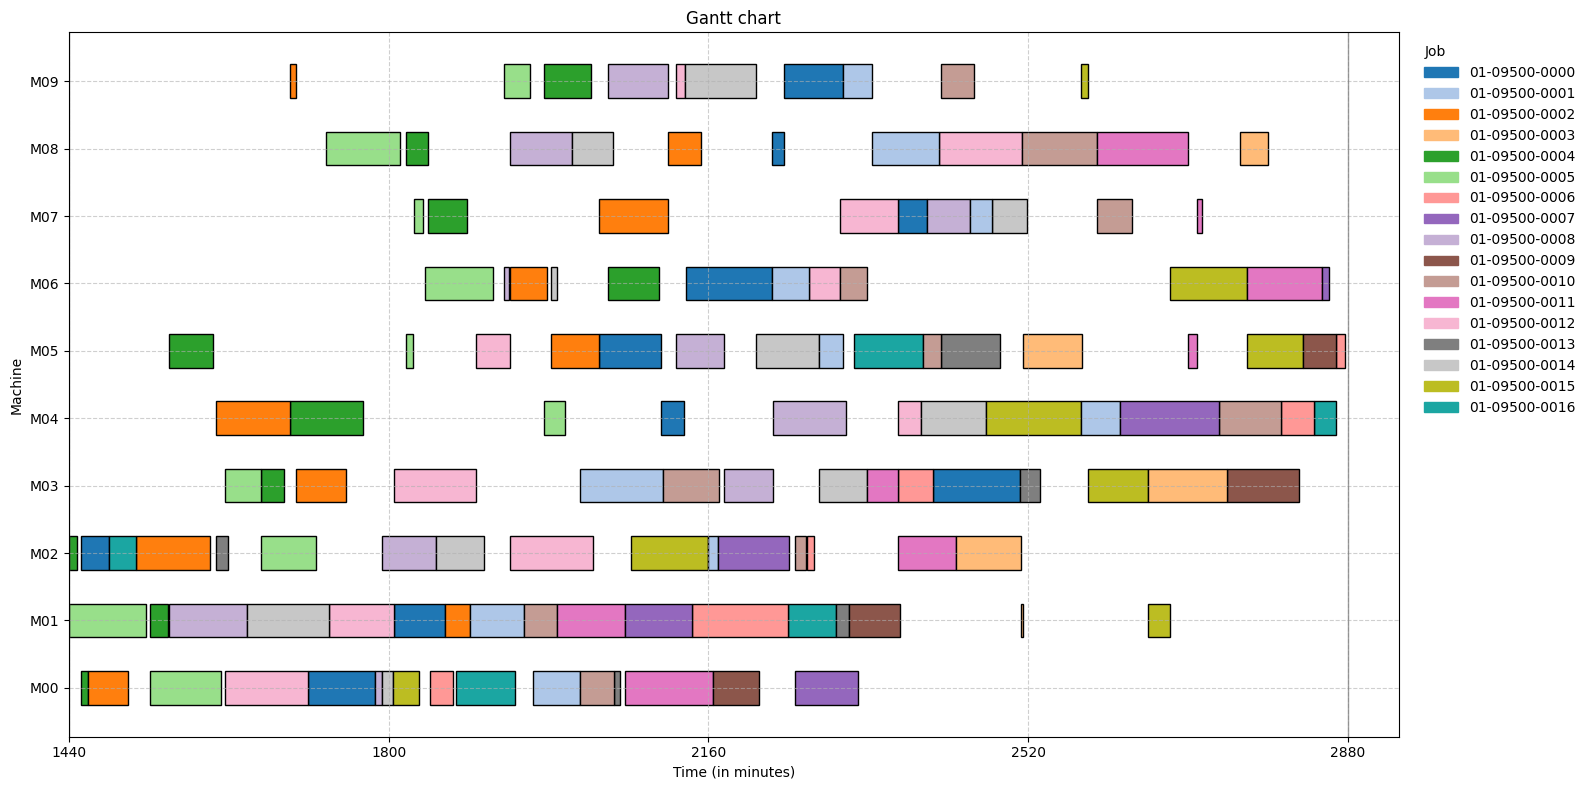

In [20]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution, perspective="Machine")
plt.show()

In [21]:
active_job_ops_collection = simulation.get_active_operation_collection()
df_active = active_job_ops_collection.to_operations_dataframe()
df_active

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0015,01-01,8,M07,2829,82,2911,1285,1440,3795
1,01-09500-0003,01-05,5,M09,2840,83,2923,155,1440,5310
2,01-09500-0007,01-03,5,M08,2859,49,2908,801,1440,4091
3,01-09500-0009,01-08,4,M02,2867,63,2930,876,1440,5910
4,01-09500-0013,01-04,5,M04,2873,64,2937,1054,1440,4647
5,01-09500-0016,01-07,5,M06,2874,76,2950,1345,1440,4197


In [22]:
waiting_job_ops_collection = simulation.get_waiting_operation_collection()
waiting_job_ops_collection.to_operations_dataframe()

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0016,01-07,6,M08,2974,19,2993,1345,1440,4197
1,01-09500-0016,01-07,7,M09,2995,48,3043,1345,1440,4197
2,01-09500-0016,01-07,8,M07,3043,36,3079,1345,1440,4197
3,01-09500-0016,01-07,9,M03,3113,79,3192,1345,1440,4197
4,01-09500-0013,01-04,6,M08,2993,21,3014,1054,1440,4647
5,01-09500-0013,01-04,7,M07,3079,49,3128,1054,1440,4647
...,...,...,...,...,...,...,...,...,...,...
22,01-09500-0009,01-08,8,M04,3242,26,3268,876,1440,5910
23,01-09500-0009,01-08,9,M08,3268,74,3342,876,1440,5910
24,01-09500-0003,01-05,6,M00,2912,47,2959,155,1440,5310


## Day 2
- This is where the new scheduling takes place, i.e., scheduling with specific consideration of the simulation.

In [23]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [24]:
# New and previous jobs that must be scheduled
current_jobs_collection_temp = jobs_collection.get_subset_by_earliest_start(earliest_start=day_start)
current_jobs_collection = current_jobs_collection_temp + waiting_job_ops_collection

In [25]:
df_jssp_current = current_jobs_collection.to_operations_dataframe()
df_jssp_current

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0003,01-05,6,M00,2912.0,47,2959.0,155,1440,5310
1,01-09500-0003,01-05,7,M06,2962.0,65,3027.0,155,1440,5310
2,01-09500-0003,01-05,8,M04,3027.0,6,3033.0,155,1440,5310
3,01-09500-0003,01-05,9,M07,3128.0,25,3153.0,155,1440,5310
4,01-09500-0006,01-00,6,M06,2812.0,62,2874.0,673,1440,4010
5,01-09500-0006,01-00,7,M07,2874.0,56,2930.0,673,1440,4010
...,...,...,...,...,...,...,...,...,...,...
242,01-09500-0038,01-05,4,M08,NaN,48,NaN,2740,2880,5805
243,01-09500-0038,01-05,5,M09,NaN,72,NaN,2740,2880,5805
244,01-09500-0038,01-05,6,M00,NaN,47,NaN,2740,2880,5805


### Scheduling (Rescheduling)

In [26]:
previous_schedule_jobs_collection = schedule_jobs_collection
df_previous_schedule = previous_schedule_jobs_collection.to_operations_dataframe()

#### a) Simple Scheduling

In [27]:
scheduler = Scheduler(
    jobs_collection=current_jobs_collection,
    schedule_start=day_start,
)

scheduler.set_active_jobs_collection(active_job_ops_collection)

schedule_jobs_collection = scheduler.get_schedule(
    priority_rule= "SLACK"
)


In [28]:
df_schedule = schedule_jobs_collection.to_operations_dataframe()
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-09500-0024,01-08,0,M00,2880,76,2956,1922,2880,4675
1,01-09500-0024,01-08,1,M01,3153,69,3222,1922,2880,4675
2,01-09500-0024,01-08,2,M03,3390,76,3466,1922,2880,4675
3,01-09500-0024,01-08,3,M05,3503,51,3554,1922,2880,4675
4,01-09500-0024,01-08,4,M02,3713,85,3798,1922,2880,4675
5,01-09500-0024,01-08,5,M09,3798,11,3809,1922,2880,4675
...,...,...,...,...,...,...,...,...,...,...
242,01-09500-0030,01-04,4,M03,4650,26,4676,2116,2880,6355
243,01-09500-0030,01-04,5,M04,4728,69,4797,2116,2880,6355
244,01-09500-0030,01-04,6,M08,4797,21,4818,2116,2880,6355


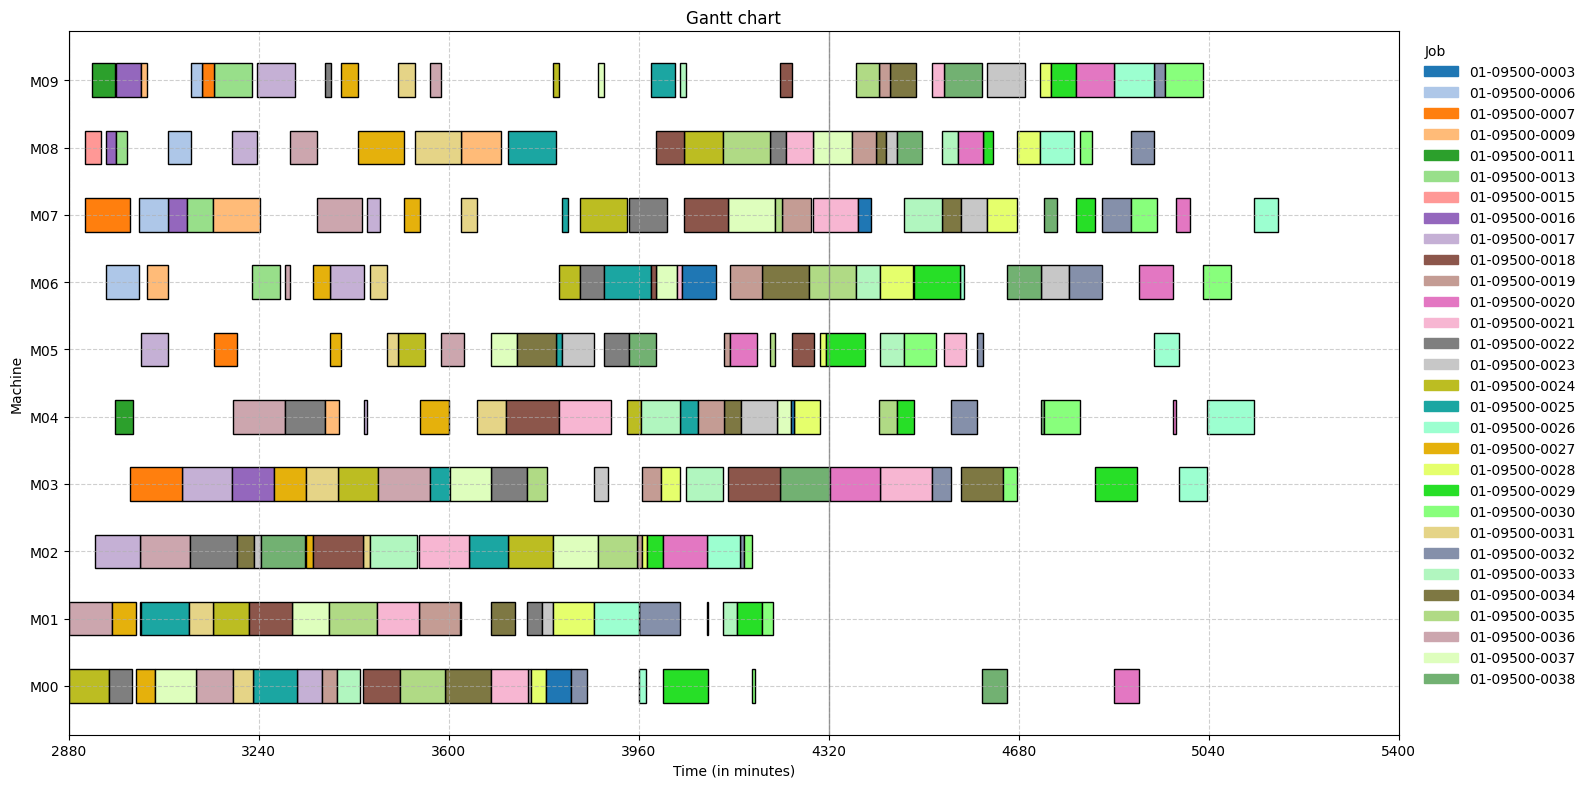

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [29]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)

In [30]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

Sum Levenshtein: 10 (over 23 shared operations)
Mean Kendall Tau: 0.42


In [31]:
df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,30,0,0,0,0,0


#### b) Deviation Prio

In [32]:
scheduler = Scheduler(
    jobs_collection=current_jobs_collection,
    schedule_start=day_start,
)

scheduler.set_active_jobs_collection(active_job_ops_collection)
scheduler.set_previous_schedule_jobs_collection(previous_schedule_jobs_collection)

schedule_jobs_collection = scheduler.get_schedule(
    priority_rule= "DEVIATION"
)
df_schedule = schedule_jobs_collection.to_operations_dataframe()

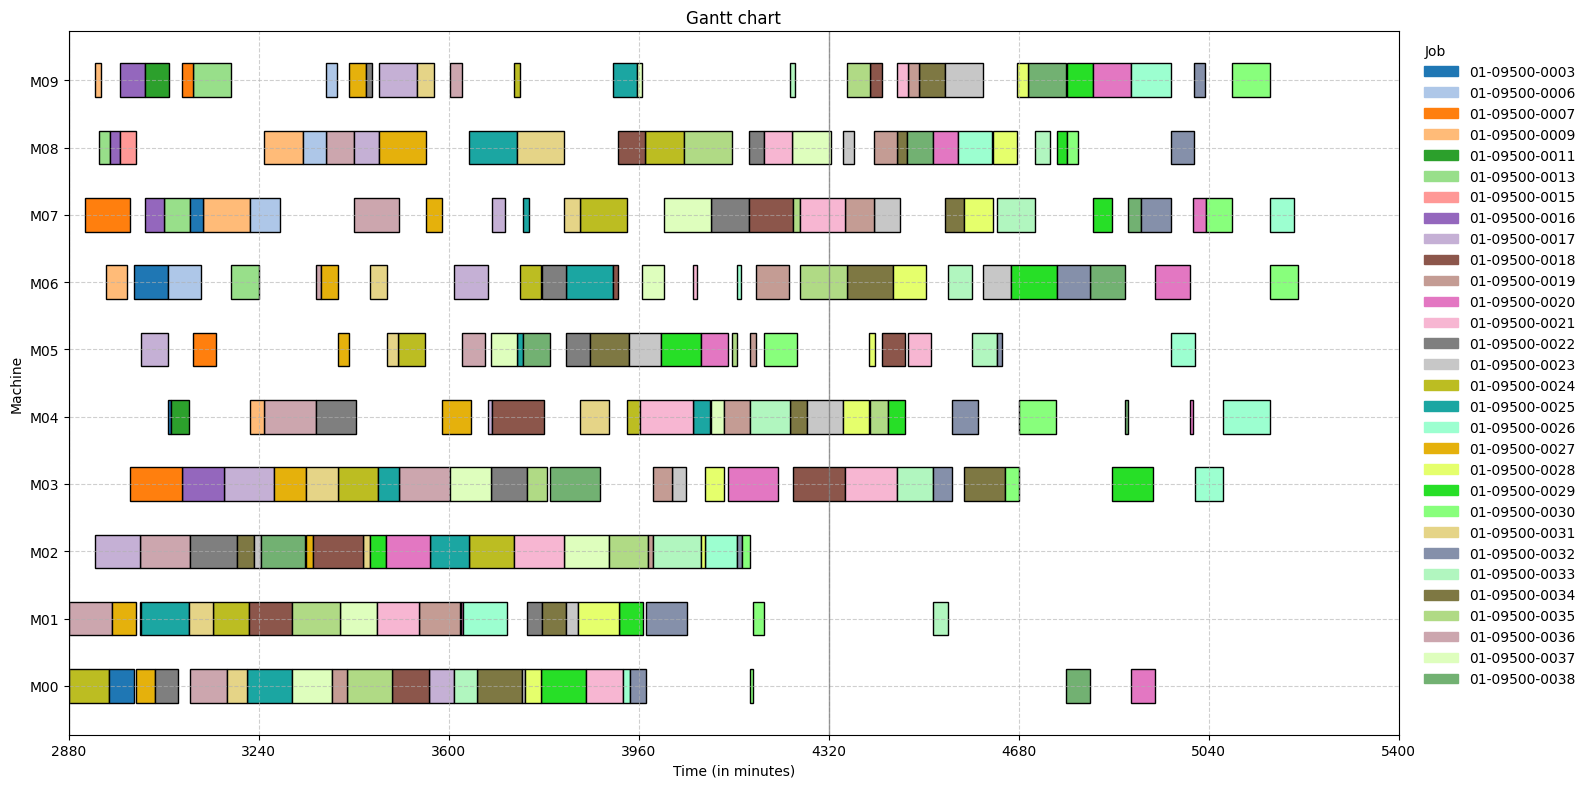

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [33]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)

In [34]:
sum_levenshtein = compute_sum_levenshtein_distance(df_previous_schedule, df_schedule, comparison_start_time=day_start)
mean_kendall_tau = compute_mean_kendall_tau(df_previous_schedule, df_schedule, comparison_start_time=day_start)
shared_operations_number = get_shared_operations_number(df_previous_schedule, df_schedule, comparison_start_time=day_start)
print(f"Sum Levenshtein: {sum_levenshtein} (over {shared_operations_number} shared operations)")
print(f"Mean Kendall Tau: {mean_kendall_tau:.2f}")

df_jobs_metrics = schedule_jobs_collection.to_jobs_metrics_dataframe()
DataFrameMetricsAnalyser.get_jobs_metrics_aggregated(df_jobs_metrics, column="Lateness", min_val= -60)

Sum Levenshtein: 7 (over 23 shared operations)
Mean Kendall Tau: 0.68


Lateness_Interval,<-60,-60 - 0,0,0 - 60,60 - 120,>120
count,30,0,0,0,0,0


#### Check the conditions of the combined data set from the simulation data with the new schedule

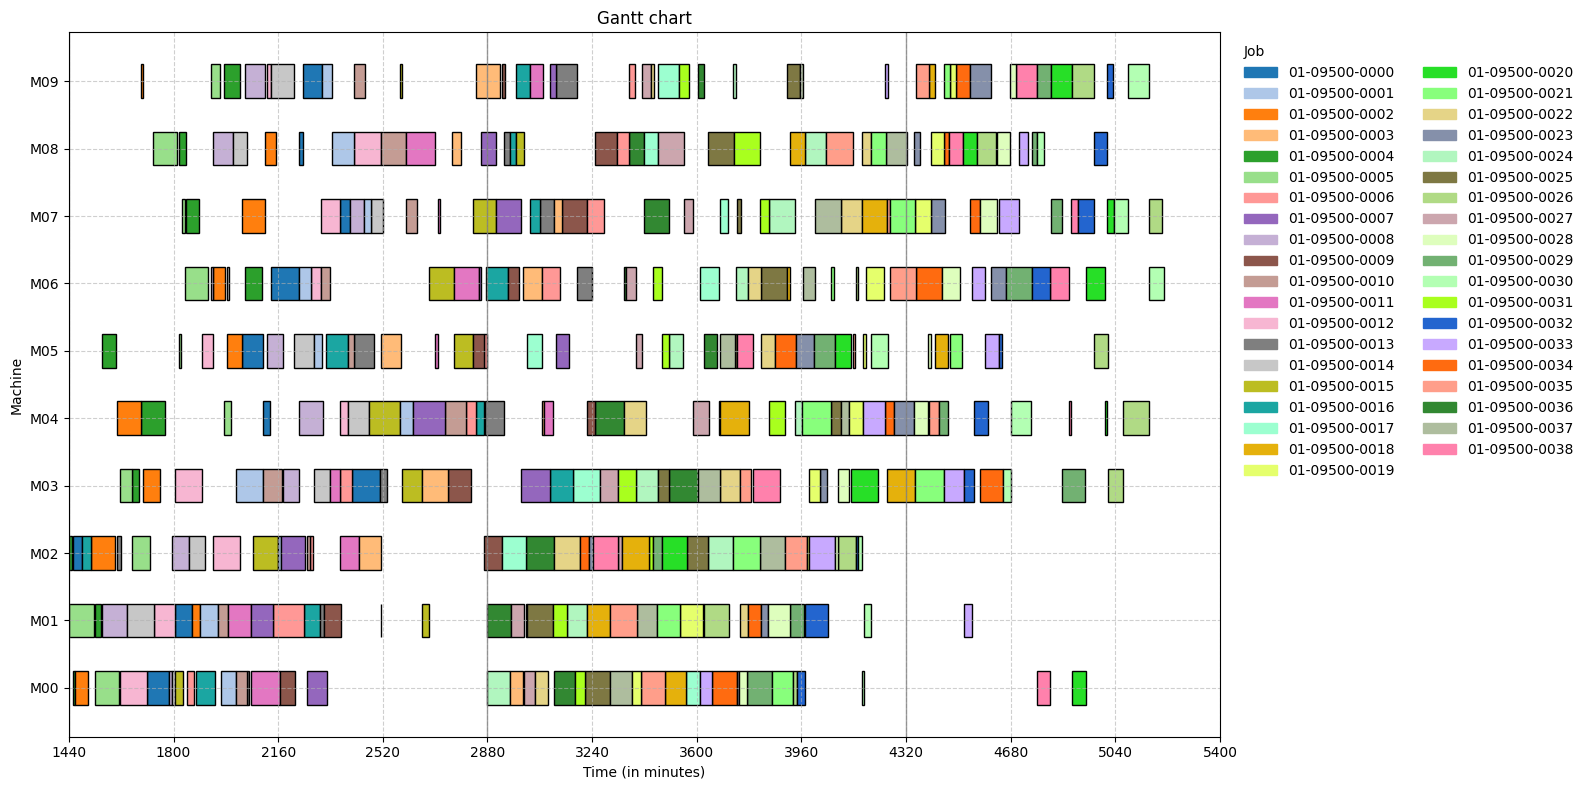

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [35]:
df_reschedule = df_schedule

columns = ["Job", "Operation", "Machine", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)

### Simulation

In [36]:
simulation.run(schedule_collection=schedule_jobs_collection, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job 01-09500-0015, Operation 8 resumed on M07 with 31 minutes left)
[Day 2 00:00:00] Job 01-09500-0003, Operation 5 resumed on M09 with 43 minutes left)
[Day 2 00:00:00] Job 01-09500-0007, Operation 5 resumed on M08 with 28 minutes left)
[Day 2 00:00:00] Job 01-09500-0009, Operation 4 resumed on M02 with 50 minutes left)
[Day 2 00:00:00] Job 01-09500-0013, Operation 5 resumed on M04 with 57 minutes left)
[Day 2 00:00:00] Job 01-09500-0016, Operation 5 resumed on M06 with 70 minutes left)
[Day 2 00:00:00] Job 01-09500-0024 started on M00
[Day 2 00:00:00] Job 01-09500-0036 started on M01
[Day 2 00:28:00] Job 01-09500-0007 finished on M08 (after 28 minutes)
[Day 2 00:31:00] Job 01-09500-0015 finished on M07 (after 31 minutes)
[Day 2 00:31:00] Job 01-09500-0007 started on M07
[Day 2 00:43:00] Job 01-09500-0003 finished on M09 (after 43 minutes)
[Day 2 00:50:00] Job 01-09500-0009 finished on M02 (after 50 minutes)
[Day 2 00:50:00] Job 01-09500-0009 started on M09
[Day 2 00:

In [37]:
finished_job_ops_collection2 = simulation.get_finished_operation_collection()
df_execution2 = finished_job_ops_collection2.to_operations_dataframe()

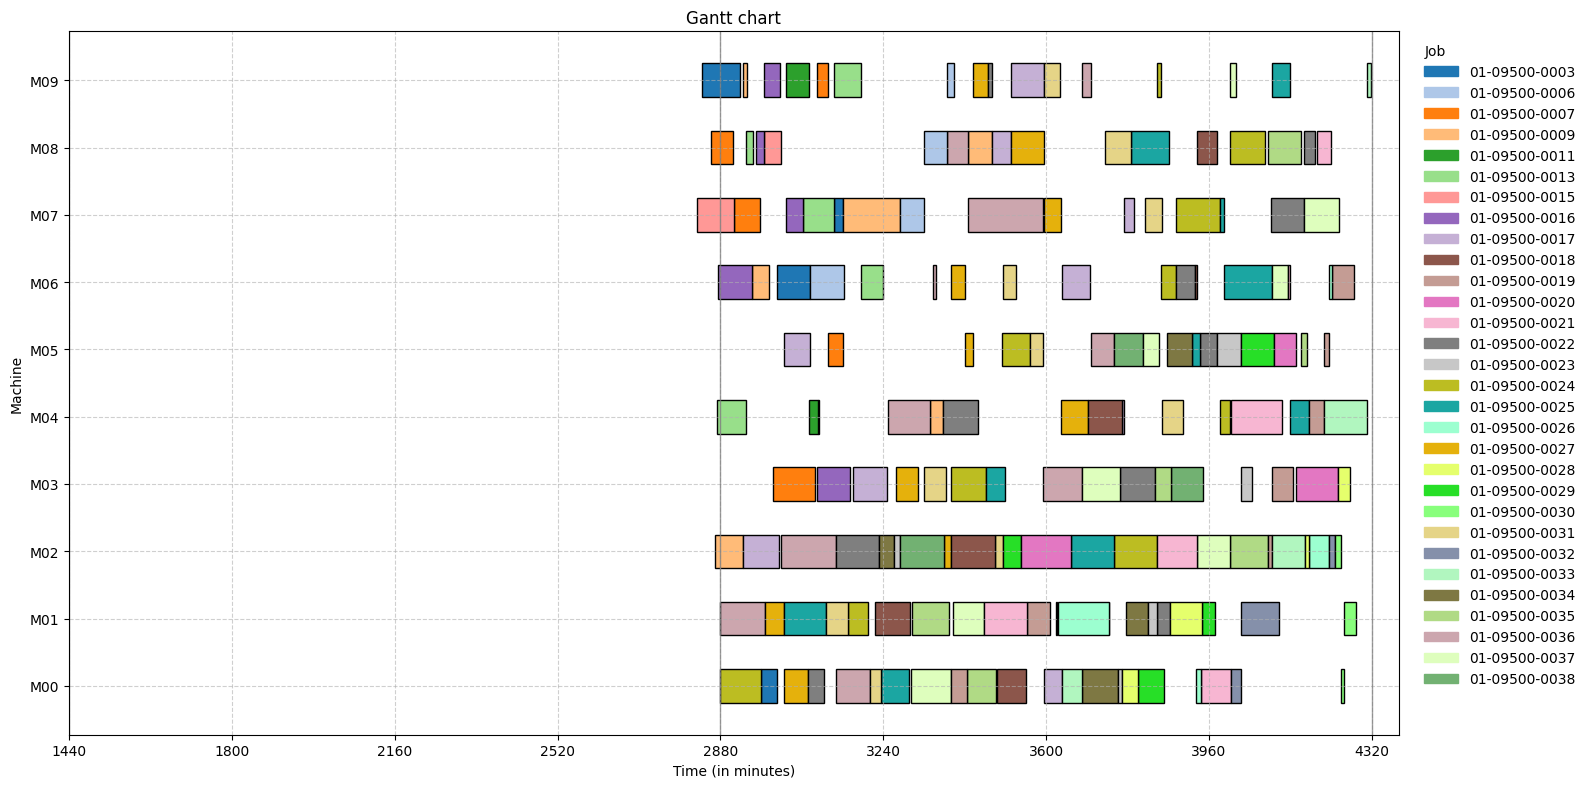

In [38]:
DataFramePlotGenerator.get_gantt_chart_figure(df_execution2, perspective="Machine")
plt.show()

#### Check the conditions of the combined data set from the two simulation data sets

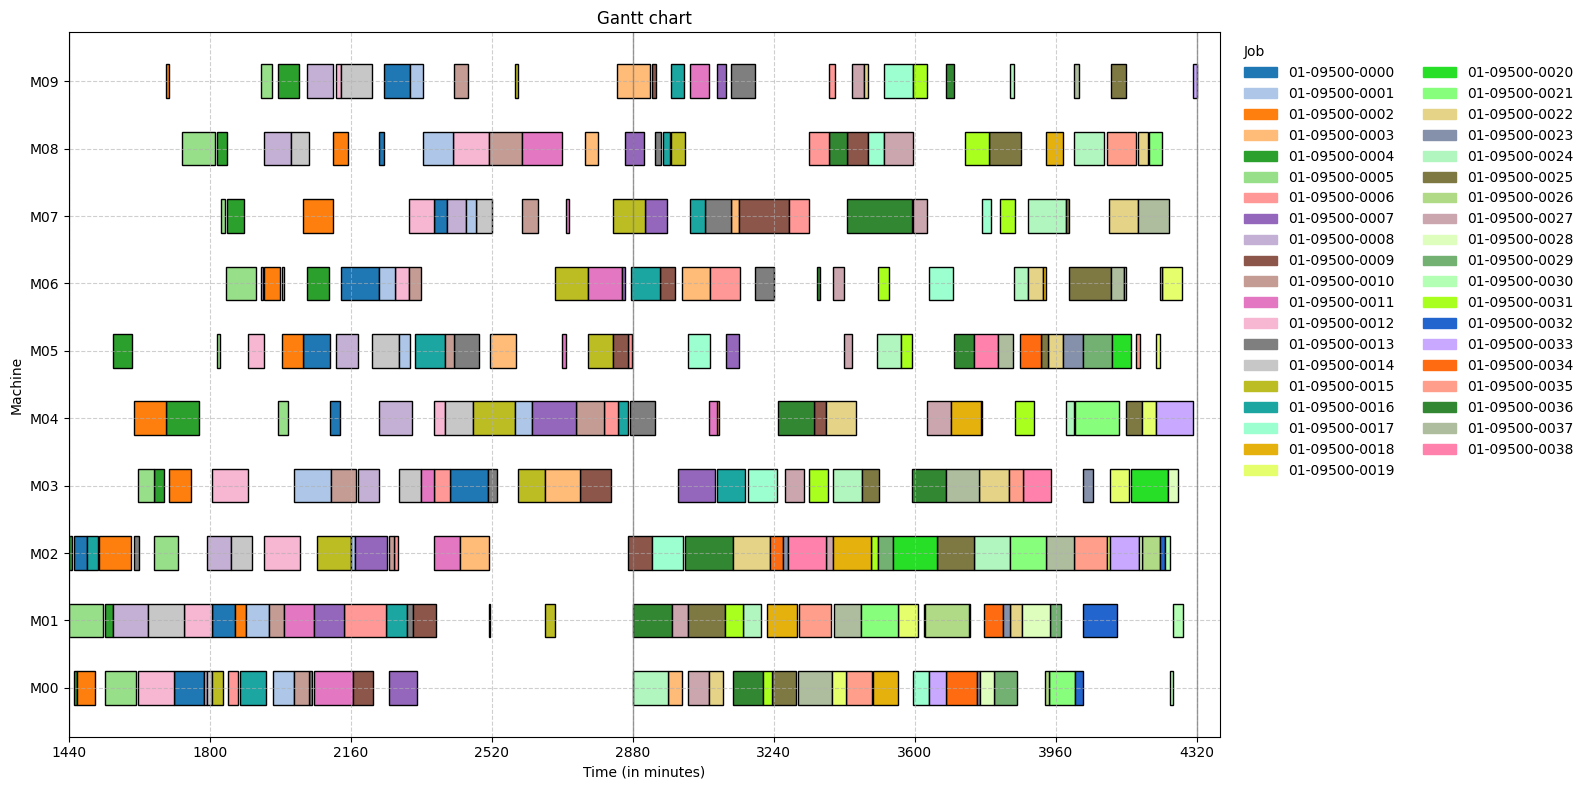

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.


True

In [39]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
DataFramePlotGenerator.get_gantt_chart_figure(df_combined, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_combined)